In [50]:
import nltk
from transformers import pipeline, AutoTokenizer
from nltk import sent_tokenize
import torch
import glob
import pandas as pd
import numpy as np

In [51]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hitesharyanacharya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [52]:
model_name = 'facebook/bart-large-mnli'
device = torch.device("mps") if torch.backends.mps.is_available() else 'cpu'

In [53]:
device

device(type='mps')

In [54]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [55]:
theme_classifier = load_model(device)

Device set to use mps


In [56]:
# friendship,hope,sacrifice,battle,self development,betrayal,love,dialogue
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [57]:
theme_classifier(
    "Whatever you do, I'll be there to protect you. Because i love you!",
    theme_list,
    multi_label=True
)

{'sequence': "Whatever you do, I'll be there to protect you. Because i love you!",
 'labels': ['love',
  'friendship',
  'hope',
  'dialogue',
  'battle',
  'sacrifice',
  'self development',
  'betrayal'],
 'scores': [0.9887236952781677,
  0.9177343249320984,
  0.7708843946456909,
  0.35626059770584106,
  0.32752370834350586,
  0.31730833649635315,
  0.2502117156982422,
  0.0066137490794062614]}

In [58]:
files = glob.glob("../data/Subtitles/*.ass")

In [59]:
files[:5]

['../data/Subtitles/Naruto Season 4 - 94.ass',
 '../data/Subtitles/Naruto Season 4 - 80.ass',
 '../data/Subtitles/Naruto Season 2 - 32.ass',
 '../data/Subtitles/Naruto Season 8 - 185.ass',
 '../data/Subtitles/Naruto Season 8 - 191.ass']

In [60]:
with open(files[0],'r') as f:
    lines = f.readlines()
    lines = lines[27:]
    lines = [",".join(line.split(',')[9:]) for line in lines]

In [61]:
lines[:2]

['We are Fighting Dreamers aiming high\n',
 "Fighting Dreamers\\Ndon't care what people think about them\n"]

In [62]:
lines = [line.replace('\\N',' ') for line in lines]

In [63]:
lines[:2]

['We are Fighting Dreamers aiming high\n',
 "Fighting Dreamers don't care what people think about them\n"]

In [64]:
int(files[0].split('-')[-1].split('.')[0].strip())

94

In [65]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob.glob(dataset_path + '/*.ass')

    scripts = []
    episode_num = []

    for path in subtitles_paths:

        # Read lines
        with open(path,'r') as f:
            lines = f.readlines()
            lines = lines[27:]
            lines = [",".join(line.split(',')[9:]) for line in lines]

        lines = [line.replace('\\N','') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode":episode_num,"script":scripts})
    return df


In [66]:
dataset_path = "../data/Subtitles/"
df = load_subtitles_dataset(dataset_path)

In [67]:
df.head()

,episode,script
0,94,We are Fighting Dreamers aiming high\n Fightin...
1,80,We are Fighting Dreamers aiming high\n Fightin...
2,32,"Press down hard on the gas\n That’s right, the..."
3,185,"Rock away your existence,\n Shouting that you ..."
4,191,"Rock away your existence,\n Shouting that you ..."


In [68]:
script = df.iloc[0]["script"]

In [69]:
script

'We are Fighting Dreamers aiming high\n Fighting Dreamersdon\'t care what people think about them\n Fighting Dreamersfollow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang)Hit it straight like a line drive!\n Right here right now (Burn)\n Down a difficult roadfilled with endless struggles\n Where do you think you are goingfollowing someone else\'s map?\n An insightful crow comes alongto tear up the map\n Now open your eyes andtake a look at the truth (Yeah!)\n There\'s nothing to lose,so let\'s GO!!!\n We are Fighting Dreamers aiming high\n Fighting Dreamersdon\'t care what people think about them\n Fighting Dreamersfollow what they believe\n Oli Oli Oli Oh!Just go my way\n Right here right now (Bang)Hit it straight like a line drive!\n Right here right now (Burn)We\'re gonna do it and do our best!\n Right here right now (Bang)Hit it straight like a line drive!\n Right here right now (Burn)We\'re gonna do it and do our best! BANG!\n My body movementshave

In [70]:
script_sentences = sent_tokenize(script)

In [71]:
# Batch Sentence
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [72]:
script_batches[1]

'Before that, I’d like to have Tsunadedo something about this body. The effects of that drugmight still last for awhile…\n There’s nothing thatI can do about it. What? Really? Geez. I guess it can’t be helped. I have no choicebut to fight in this condition. Tsunade… Rest your bodywith Recovery Ninjutsu. Then… What about me, me? You guard Tsunade togetherwith that pig. What?! I want to fight, too.Even I can--\n No, you won’t! Like that four-eyed kid said, right? You’re on a different level. The opponent is a Sannin like myself,\n and the man who killedthe Third Hokage. An eye for an eye…I’m the only one who can fight him. And that four-eyed guy possessesthe same level of power as Kakashi. Okay. Then… Shadow Clo--\n Hold it! Don’t use the Shadow Clone Jutsu.lt’d be utterly pointless.'

In [73]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [74]:
theme_output

[{'sequence': "We are Fighting Dreamers aiming high\n Fighting Dreamersdon't care what people think about them\n Fighting Dreamersfollow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang)Hit it straight like a line drive! Right here right now (Burn)\n Down a difficult roadfilled with endless struggles\n Where do you think you are goingfollowing someone else's map? An insightful crow comes alongto tear up the map\n Now open your eyes andtake a look at the truth (Yeah!) There's nothing to lose,so let's GO!!! We are Fighting Dreamers aiming high\n Fighting Dreamersdon't care what people think about them\n Fighting Dreamersfollow what they believe\n Oli Oli Oli Oh!Just go my way\n Right here right now (Bang)Hit it straight like a line drive! Right here right now (Burn)We're gonna do it and do our best! Right here right now (Bang)Hit it straight like a line drive! Right here right now (Burn)We're gonna do it and do our best! BANG! My body movementshave finally 

In [75]:
themes = {}
for theme in theme_output:
    for label, score in zip(theme['labels'], theme['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [76]:
themes = {key: np.mean(np.array(value)) for key, value in themes.items()}

In [77]:
themes

{'battle': np.float64(0.9201798141002655),
 'dialogue': np.float64(0.8766730725765228),
 'self development': np.float64(0.7682983875274658),
 'betrayal': np.float64(0.750927597284317),
 'sacrifice': np.float64(0.7735238373279572),
 'hope': np.float64(0.19807565212249756),
 'friendship': np.float64(0.08282825537025928),
 'love': np.float64(0.03925992641597986)}

In [78]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch Sentence
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle output
    themes = {}
    for theme in theme_output:
        for label, score in zip(theme['labels'], theme['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key, value in themes.items()}

    return themes


In [79]:
df = df.head(2)

In [80]:
df

,episode,script
0,94,We are Fighting Dreamers aiming high\n Fightin...
1,80,We are Fighting Dreamers aiming high\n Fightin...


In [81]:
output_themes = df["script"].apply(get_themes_inference)

In [82]:
output_themes

0    {'battle': 0.9201798141002655, 'dialogue': 0.8...
1    {'dialogue': 0.9497761130332947, 'battle': 0.9...
Name: script, dtype: object

In [83]:
themes_df = pd.DataFrame(output_themes.tolist())

In [84]:
themes_df

,battle,dialogue,self development,betrayal,sacrifice,hope,friendship,love
0,0.92018,0.876673,0.768298,0.750928,0.773524,0.198076,0.082828,0.039260
1,0.91695,0.949776,0.661953,0.685841,0.666984,0.402813,0.147897,0.045928


In [85]:
df

,episode,script
0,94,We are Fighting Dreamers aiming high\n Fightin...
1,80,We are Fighting Dreamers aiming high\n Fightin...


In [86]:
df[themes_df.columns] = themes_df
df

,episode,script,battle,dialogue,self development,betrayal,sacrifice,hope,friendship,love
0,94,We are Fighting Dreamers aiming high\n Fightin...,0.92018,0.876673,0.768298,0.750928,0.773524,0.198076,0.082828,0.039260
1,80,We are Fighting Dreamers aiming high\n Fightin...,0.91695,0.949776,0.661953,0.685841,0.666984,0.402813,0.147897,0.045928


In [87]:
df

,episode,script,battle,dialogue,self development,betrayal,sacrifice,hope,friendship,love
0,94,We are Fighting Dreamers aiming high\n Fightin...,0.92018,0.876673,0.768298,0.750928,0.773524,0.198076,0.082828,0.039260
1,80,We are Fighting Dreamers aiming high\n Fightin...,0.91695,0.949776,0.661953,0.685841,0.666984,0.402813,0.147897,0.045928


In [88]:
df = df.drop ('dialogue', axis=1)

In [90]:
theme_output = df.drop(['episode','script'], axis=1).sum().reset_index()
theme_output.columns = ['theme','score']

In [91]:
theme_output

,theme,score
0,battle,1.837129
1,self development,1.430252
2,betrayal,1.436769
3,sacrifice,1.440508
4,hope,0.600889
5,friendship,0.230725
6,love,0.085188


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

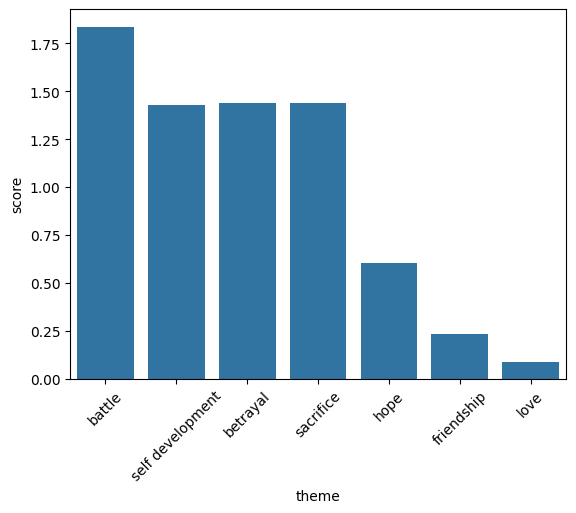

In [94]:
sns.barplot(x="theme", y="score", data=theme_output)
plt.xticks(rotation=45)
plt.show()